# Week 17
## Ensemble Learning and Random Forest

In [47]:
# Dependencies and modules:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm

from pprint import pp

from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVC

## 1. What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class.

Deductive reasoning is a logical top-down path where you start with a known, evaluate new information, and follow that information to its logical conclusion. For example, if you know I have three things in my pocket and I pull out a Swiss army knife and a roll of duct tape, you can deduce that I now have one thing in my pocket. 

Inductive reasoning is more bottom-up thinking. You see the hole that was in my hot air balloon is now patched with duct-tape. Then you see that the access panel on the burner has been opened via removal of it's six screws and some faulty wiring has been cut, stripped, and re-connected. You see a Swiss army knife on the floor of the basket surrounded by six screws. You can reason from these observations that I had at least two things in my pocket when boarding the hot air balloon.

## Using ONE of the following sources, complete the questions for only that source. 

Credit approval: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29

Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 

Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone - this one is a bit harder since it’s not binary like the others, but if you really want to master these concepts, you should pick this one. Use RMSE as a performance metric if you do this as regression. You should target a value of under 3.

#### Note: at least one of your models should have the most relevant performance metric above .90 . All performance metrics should be above .75 . You will partially be graded on model performance.


### Reading in files and creating a dataframe of the data:

In [3]:
# The download consisted of a .names file and a .data file. I will extract column names
# from the .name file for the dataframe that will wold the .data data.

with open("abalone.names") as f:
    print(f.read())

1. Title of Database: Abalone data

2. Sources:

   (a) Original owners of database:
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

   (b) Donor of database:
	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
	Department of Computer Science, University of Tasmania
	GPO Box 252C, Hobart, Tasmania 7001, Australia

   (c) Date received: December 1995


3. Past Usage:

   Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD
   thesis, Computer Science Department, University of Tasmania.

   -- Test set performance (final 1044 examples, first 3133 used for training):
	24.86% Cascade-Correlation (no hidden nodes)
	26.25% Cascade-Correlation (5 hidden nodes)
	21.5%  C4.5
	 0.0%  Linear Discriminate Analysis
	 3.57% k=5 Nearest Neighbour
      (Problem encoded as a classification task)

   -- Data set samp

In [4]:
# abalone.csv
abalone_df = pd.read_csv('abalone.data',header=None, names=['Sex',
                                                            'Length',
                                                            'Diameter',
                                                            'Height',
                                                            'Whole weight',
                                                            'Shucked weight',
                                                            'Viscera weight',
                                                            'Shell weight',
                                                            'Rings',])
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## 2. Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t. 

Here is a recap of various pre-processing we have done over the last month:
* NaN handling (columns vs. rows, fillna vs. dropna, imputation)
* data type handling
* Imbalanced Learning (stratified sampling, oversampling, undersampling)
* outlier detection and/or removal
* standardizing data (regularization, normalizing, scaling)
* feature engineering (categorical vs. numerical vs. strings, binary vs. one-hot, average vs. datetime, extraction vs. tf/idf)
* feature selection (redundant, correlated, dimensionality reduction)

This dataset comes with some pre-processing already done. There are no NaNs, datatypes are numerical (except for sex), and data has been scaled. I will verify these points:

In [5]:
# Verifying documentation-asserted pre-processing:
print('Data variance: ')
print(abalone_df.var(numeric_only=True))
print(' ')
print("Data NaNs: ")
print(abalone_df.isnull().sum().sort_values())
print(' ')
print('Data Types: ')
print(abalone_df.dtypes)

Data variance: 
Length             0.014422
Diameter           0.009849
Height             0.001750
Whole weight       0.240481
Shucked weight     0.049268
Viscera weight     0.012015
Shell weight       0.019377
Rings             10.395266
dtype: float64
 
Data NaNs: 
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64
 
Data Types: 
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


I first want to create a new column for age, as it is our output variable. Per the dataset documentation, abalone age in years is equal to Rings + 1.5. Then I will factorize the sex column. After that, I will check a heatmap to visualize feature correlation. Then I want to check for outliers with a quick box plot; I can think of scenarious where outliers could be present (an abalone that lived for many years with its length constrained because it was tangled in a plastic net or something). After I scrub outliers, I will perform SMOGN, synthetic minority oversampling for Gaussian noise. Then I will perform a statistical feature selection.

### Feature engineering:

In [6]:
# Age column creation and replacement of Rings column:
abalone_df['Age in years'] = abalone_df['Rings']+1.5
abalone = abalone_df.drop('Rings', axis=1)
abalone.head(2)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age in years
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,8.5


In [7]:
# Factorizing the sex column and preserving a key of sex codes for reference:
column = ['Sex']
for i in column:
    abalone["Coded "+i] = pd.factorize(abalone[i])[0]+1
    code_key = pd.DataFrame(abalone[i])
    code_key["Code for "+i]=abalone["Coded "+i]
    abalone = abalone.drop(i,axis=1)
    print(code_key[[i,"Code for "+i]].value_counts())

Sex  Code for Sex
M    1               1528
I    3               1342
F    2               1307
dtype: int64


In [8]:
abalone.head(2)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age in years,Coded Sex
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,16.5,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,8.5,1


### Heatmap to show correlation (and multicollinearity):

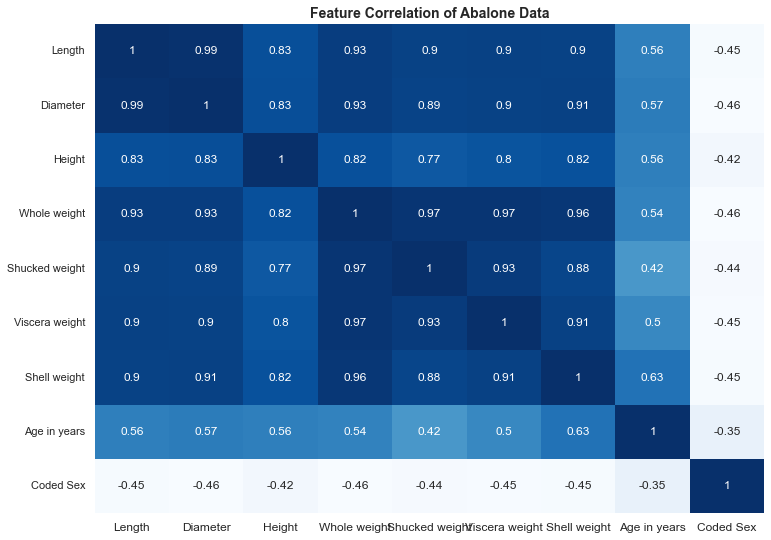

In [14]:
# plotting the heatmap
correlation = abalone.corr()
g = sns.heatmap(correlation, annot=True, linewidth=0, cmap="Blues",cbar=False)
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 12)
g.set_title('Feature Correlation of Abalone Data',size=14, weight='bold')
sns.set(rc={'figure.figsize':(12,9)})

Obviously the many weight columns have strong multicolinnearity. I will have to cull those down. I will run a feature importance module to determine which should go.

### Box plots to show outliers:

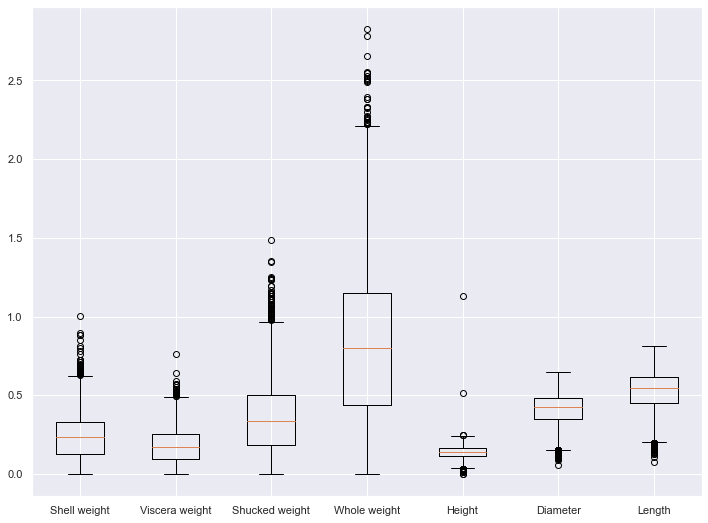

In [15]:
plt.boxplot([abalone['Shell weight'],abalone['Viscera weight'],abalone['Shucked weight'],abalone['Whole weight'],abalone['Height'],abalone['Diameter'],abalone['Length']],labels=['Shell weight', 'Viscera weight','Shucked weight', 'Whole weight', 'Height', 'Diameter', 'Length'])
plt.show()

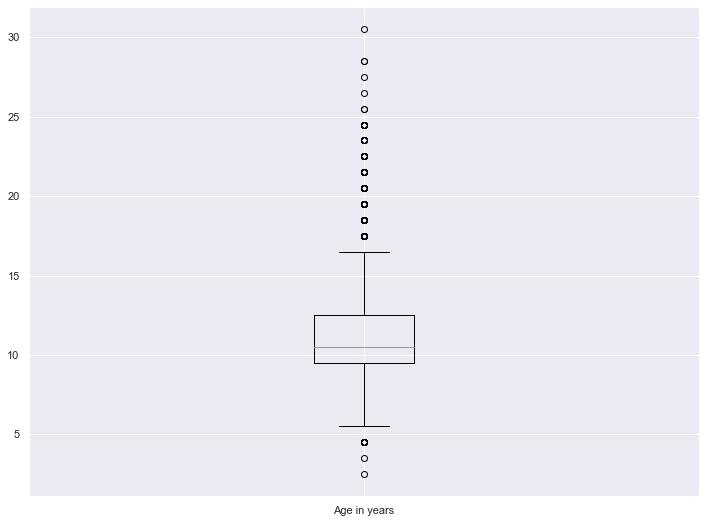

In [16]:
plt.boxplot(abalone['Age in years'],labels= ['Age in years'])
plt.show()

In this visual, we can see that we have outliers in every column. I will try IsolationForest to identify and remove them. I will need to split into test/training sets to move further.

### Random Forest Feature Importance:

In [17]:
# prepare my X and y:
X = abalone.drop('Age in years',axis=1).values
y = abalone['Age in years'].values

# Split into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
# Examine shape of the training dataset:
print(X_train.shape, y_train.shape)

(2798, 8) (2798,)


Feature: 0, Score: 0.04815
Feature: 1, Score: 0.05184
Feature: 2, Score: 0.05227
Feature: 3, Score: 0.08511
Feature: 4, Score: 0.16240
Feature: 5, Score: 0.07266
Feature: 6, Score: 0.49971
Feature: 7, Score: 0.02786


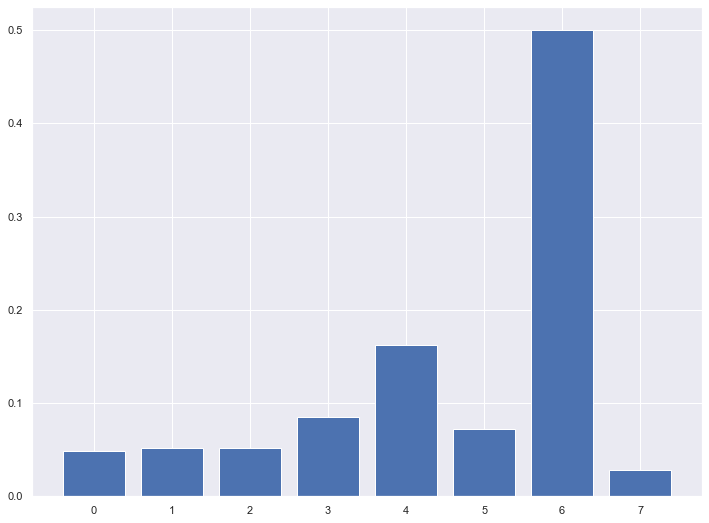

In [18]:
# instantiate my classifier and fit it to my dataset:
rf = RandomForestRegressor()
rf.fit(X,y)

# define the classifier's feature importance property:
importance= rf.feature_importances_

# Report feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot the importance for a quick visual:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Shell weight is the clear winner in the survival game between the weight features. I will drop the others.

#### Since I ran the regresor for the property, I might as well view the model perfomance:

In [19]:
# Baseline performance:
y_pred = rf.predict(X_test)

# Report:
mse = mean_squared_error(y_test, y_pred)
rms = mse**(1/2)

print("MSE = "+str(mse))
print("RMSE = "+str(rms))

MSE = 0.6672089195068891
RMSE = 0.8168285741248827


### Dropping features with strong multicollinearity:

In [20]:
abalone6 = abalone.drop(['Whole weight', 'Viscera weight', 'Shucked weight'],axis=1)
abalone6

,Length,Diameter,Height,Shell weight,Age in years,Coded Sex
0,0.455,0.365,0.095,0.1500,16.5,1
1,0.350,0.265,0.090,0.0700,8.5,1
2,0.530,0.420,0.135,0.2100,10.5,2
3,0.440,0.365,0.125,0.1550,11.5,1
4,0.330,0.255,0.080,0.0550,8.5,3
...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.2490,12.5,2
4173,0.590,0.440,0.135,0.2605,11.5,1
4174,0.600,0.475,0.205,0.3080,10.5,1
4175,0.625,0.485,0.150,0.2960,11.5,2


In [21]:
# preparing my new X and y:
X6 = abalone6.drop('Age in years',axis=1).values
y6 = abalone6['Age in years'].values
# Examine shape:
print(X6.shape, y6.shape)

(4177, 5) (4177,)


In [22]:
# Split the new dataset:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size = 0.33, random_state=42)

# Running model again to see difference:
rf6 = RandomForestRegressor()
rf6.fit(X_train6,y_train6)

y_pred6 = rf6.predict(X_test6)

# Report:
mse6 = mean_squared_error(y_test6, y_pred6)
rms6 = mse6**(1/2)

print("MSE = "+str(mse6))
print("RMSE = "+str(rms6))


MSE = 5.597529139513334
RMSE = 2.3659097910768563


The model looks like it performed worse, but that could be because strong multicollinearity inflates performance metrics.

### Identifying and removing outliers:

In [23]:
# instantiate my Isolation Forest:
iso = IsolationForest(contamination=0.1)
# identify outliers with module:
y_predo =iso.fit_predict(X6)
# slice for rows that don't have outliers:
mask = y_predo != -1
Xo, yo = X6[mask, :], y6[mask]
# Examine shape of scrubbed training dataset:
print(Xo.shape, yo.shape)

(3759, 5) (3759,)


In [24]:
# The isolation forest identified and removed 418 rows or around 10%
# of the total data. That seems reasonable. Let's see how it affected 
# regression performance:

# Split the modified dataset:
X_traino, X_testo, y_traino, y_testo = train_test_split(Xo, yo, test_size = 0.33, random_state=42)

# instantiate the classifier and fit it to my dataset:
rfo = RandomForestRegressor()
rfo.fit(X_traino, y_traino)

y_pred_rfo = rfo.predict(X_testo) 

# Report:
mseo = mean_squared_error(y_testo, y_pred_rfo)
rmso = mseo**(1/2)

print("MSE = "+str(mseo))
print("RMSE = "+str(rmso))

MSE = 5.66026819401916
RMSE = 2.379131815183673


That actually worsened performance. I will move forward with these two datasets side-by-side for learning purposes. Next I will use a form of oversampling specifically for regression: SMOGN. 
##### Edit: SMOGN did not work; a problem with the module code. I will move on without SMOGNing.

### Statistical Feature Selection:

#### For whole dataset:

In [25]:
# For Whole Dataset:
#Instantiate my feature selector:
fs = SelectKBest(score_func=f_regression, k=4)
# Fit training data
fs.fit(X_train6, y_train6)
# transform train input data
X_train_fs = fs.transform(X_train6)
#transform test input data
X_test_fs = fs.transform(X_test6)

Feature 0: 1213.871865
Feature 1: 1316.783033
Feature 2: 1167.435214
Feature 3: 1803.909527
Feature 4: 363.896874


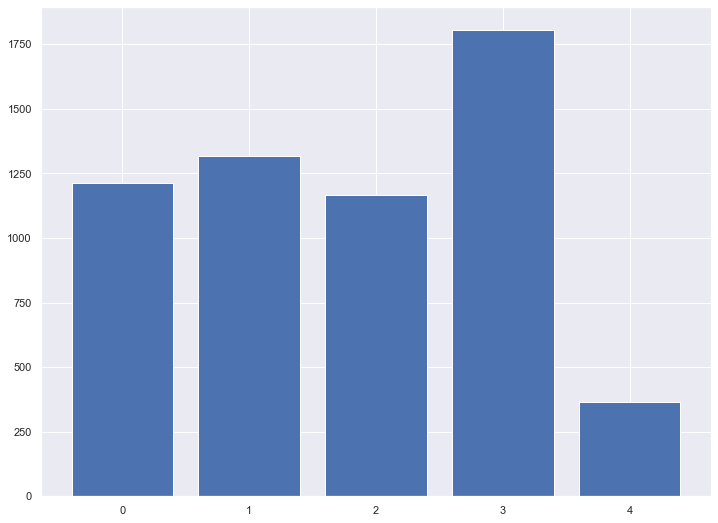

In [26]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Ok, I will rerun the selctor, setting k value to 6.

#### For Outlier-removed set:

In [27]:
# Using statistical feature selection on the dataset with outliers removed:

#Instantiate my feature selector:
fso = SelectKBest(score_func=f_regression, k=4)
# Fit training data
fso.fit(X_traino,y_traino)
# transform train input data
X_train_fso = fso.transform(X_traino)
#transform test input data
X_test_fso = fso.transform(X_testo)

Feature 0: 668.491697
Feature 1: 753.211731
Feature 2: 1019.343864
Feature 3: 1135.802033
Feature 4: 340.423301


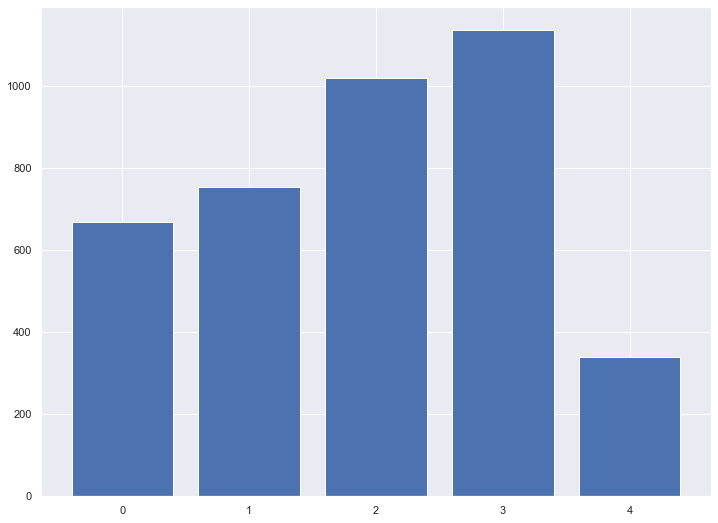

In [28]:
# what are scores for the features
for i in range(len(fso.scores_)):
	print('Feature %d: %f' % (i, fso.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fso.scores_))], fso.scores_)
plt.show()

Alright, same thing: k=4.

## 3. Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.

### Running model on whole 6-column dataset:

In [35]:
# Instantiate the classifier and fit it to my dataset:
tree = DecisionTreeRegressor(random_state=42)

# Create the model and get predicted values:
tree = tree.fit(X_train_fs, y_train6)
y_predt = tree.predict(X_test_fs)

# Report:
mset = mean_squared_error(y_test6, y_predt)
rmst = mset**(1/2)

print("MSE = "+str(mset))
print("RMSE = "+str(rmst))

MSE = 10.771392313270486
RMSE = 3.281979937975015


### Using RandomizedSearchCV to find best hyperparameters:

In [36]:
# Method of evaluation:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
space = dict()
space['criterion'] = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
space['ccp_alpha'] = loguniform(1e-5, 100)
space['splitter'] = ['best', 'random']

# definingand running the search
search = RandomizedSearchCV(tree, space, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
result = search.fit(X_train_fs, y_train6)

# Report:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -2.456324754682308
Best Hyperparameters: {'ccp_alpha': 0.03796617034906454, 'criterion': 'squared_error', 'splitter': 'random'}


#### Tuning the parameters made a significant improvement on model performance. I used the RandomizedSearchCV to identify optimum hyperparameter settings instead of GridSearch because Random Search is faster and less processing-intense. I chose hyperparameters to search that optimized accuracy and not on the ones that optimize performance (such as limiting leaf splits or nodes). Beyond that, I referenced Machine Learning Mastery for code setup ideas and for help understanding which hyperparameters were most important for the module. 

### Outliers Removed:

In [37]:
# Instantiate the classifier and fit it to my whole dataset:
treeo = DecisionTreeRegressor(random_state=42)

# Create the model and get predicted values:
treeo = treeo.fit(X_train_fso, y_traino)
y_predto = treeo.predict(X_test_fso)

# Report:
mseto = mean_squared_error(y_testo, y_predto)
rmsto = mset**(1/2)

print("MSE = "+str(mseto))
print("RMSE = "+str(rmsto))

MSE = 10.710314262691378
RMSE = 3.281979937975015


### Using RandomizedSearchCV to find best hyperparameters:

In [38]:
# Method of evaluation:
cvo = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
spaceo = dict()
spaceo['criterion'] = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
spaceo['ccp_alpha'] = loguniform(1e-5, 100)
spaceo['splitter'] = ['best', 'random']

# defining and running the search
searcho = RandomizedSearchCV(treeo, spaceo, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cvo, random_state=42)
resulto = searcho.fit(X_train_fso, y_traino)

# Report:
print('Best Score: %s' % resulto.best_score_)
print('Best Hyperparameters: %s' % resulto.best_params_)

Best Score: -2.37472870879803
Best Hyperparameters: {'ccp_alpha': 0.0509981061407342, 'criterion': 'friedman_mse', 'splitter': 'best'}


#### Again, it is obvious that big gains are to be had by tuning the model. This instance shows that the extra layers of pre-processing squeaked me out a tiny bit more accuracy on the un-tuned model, but tuned performance is almost identical.

## 4. Create a random forest model tuned to the best of your abilities. Explain how you tuned it.

### Whole 6-column dataset:

In [43]:
# Code from my check up above:
rf6 = RandomForestRegressor(random_state=42)
rf6.fit(X_train6,y_train6)

y_pred6 = rf6.predict(X_test6)

# Report:
mse6 = mean_squared_error(y_test6, y_pred6)
rms6 = mse6**(1/2)

print("MSE = "+str(mse6))
print("RMSE = "+str(rms6))

MSE = 5.63095310005155
RMSE = 2.3729629369317067


### Using RandomizedSearchCV to find best hyperparameters:

In [41]:
# Method of evaluation:
cvrf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
spacerf = dict()
spacerf['criterion'] = ['squared_error', 'absolute_error', 'poisson']
spacerf['ccp_alpha'] = loguniform(1e-5, 100)
spacerf['bootstrap'] = [True]
spacerf['oob_score'] = [True,False]
spacerf['max_samples'] = np.arange(0.1,1.0,0.1)
spacerf['n_estimators'] = randint(24,1000)

# defining and running the search
searchrf = RandomizedSearchCV(rf6, spacerf, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cvrf, random_state=42)
resultrf = searchrf.fit(X_train_fs, y_train6)

# Report:
print('Best Score: %s' % resultrf.best_score_)
print('Best Hyperparameters: %s' % resultrf.best_params_)

C:\Python\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
8370 fits failed out of a total of 15000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7740 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python\lib\site-packages\sklearn\ensemble\_forest.py", line 379, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

--------------------------------------------------------------------------------
630 fits failed with the 

building tree 1 of 915
building tree 2 of 915
building tree 3 of 915
building tree 4 of 915
building tree 5 of 915
building tree 6 of 915
building tree 7 of 915
building tree 8 of 915
building tree 9 of 915
building tree 10 of 915
building tree 11 of 915


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  2

building tree 12 of 915
building tree 13 of 915
building tree 14 of 915
building tree 15 of 915
building tree 16 of 915
building tree 17 of 915
building tree 18 of 915
building tree 19 of 915
building tree 20 of 915
building tree 21 of 915
building tree 22 of 915
building tree 23 of 915
building tree 24 of 915
building tree 25 of 915
building tree 26 of 915
building tree 27 of 915


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s remaining:    0.0s


building tree 28 of 915
building tree 29 of 915
building tree 30 of 915
building tree 31 of 915
building tree 32 of 915
building tree 33 of 915
building tree 34 of 915
building tree 35 of 915
building tree 36 of 915
building tree 37 of 915
building tree 38 of 915
building tree 39 of 915
building tree 40 of 915
building tree 41 of 915
building tree 42 of 915
building tree 43 of 915
building tree 44 of 915
building tree 45 of 915
building tree 46 of 915
building tree 47 of 915
building tree 48 of 915
building tree 49 of 915
building tree 50 of 915
building tree 51 of 915
building tree 52 of 915
building tree 53 of 915
building tree 54 of 915
building tree 55 of 915
building tree 56 of 915
building tree 57 of 915
building tree 58 of 915
building tree 59 of 915
building tree 60 of 915
building tree 61 of 915
building tree 62 of 915
building tree 63 of 915
building tree 64 of 915
building tree 65 of 915
building tree 66 of 915
building tree 67 of 915
building tree 68 of 915
building tree 69

building tree 362 of 915
building tree 363 of 915
building tree 364 of 915
building tree 365 of 915
building tree 366 of 915
building tree 367 of 915
building tree 368 of 915
building tree 369 of 915
building tree 370 of 915
building tree 371 of 915
building tree 372 of 915
building tree 373 of 915
building tree 374 of 915
building tree 375 of 915
building tree 376 of 915
building tree 377 of 915
building tree 378 of 915
building tree 379 of 915
building tree 380 of 915
building tree 381 of 915
building tree 382 of 915
building tree 383 of 915
building tree 384 of 915
building tree 385 of 915
building tree 386 of 915
building tree 387 of 915
building tree 388 of 915
building tree 389 of 915
building tree 390 of 915
building tree 391 of 915
building tree 392 of 915
building tree 393 of 915
building tree 394 of 915
building tree 395 of 915
building tree 396 of 915
building tree 397 of 915
building tree 398 of 915
building tree 399 of 915
building tree 400 of 915
building tree 401 of 915


building tree 708 of 915
building tree 709 of 915
building tree 710 of 915
building tree 711 of 915
building tree 712 of 915
building tree 713 of 915
building tree 714 of 915
building tree 715 of 915
building tree 716 of 915
building tree 717 of 915
building tree 718 of 915
building tree 719 of 915
building tree 720 of 915
building tree 721 of 915
building tree 722 of 915
building tree 723 of 915
building tree 724 of 915
building tree 725 of 915
building tree 726 of 915
building tree 727 of 915
building tree 728 of 915
building tree 729 of 915
building tree 730 of 915
building tree 731 of 915
building tree 732 of 915
building tree 733 of 915
building tree 734 of 915
building tree 735 of 915
building tree 736 of 915
building tree 737 of 915
building tree 738 of 915
building tree 739 of 915
building tree 740 of 915
building tree 741 of 915
building tree 742 of 915
building tree 743 of 915
building tree 744 of 915
building tree 745 of 915
building tree 746 of 915
building tree 747 of 915


[Parallel(n_jobs=1)]: Done 915 out of 915 | elapsed:    9.9s finished


Best Score: -2.2723784784037044
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0009055707630309611, 'criterion': 'absolute_error', 'max_samples': 0.2, 'n_estimators': 915, 'oob_score': True, 'verbose': 36}


#### Outlier-removed dataset:

In [50]:
# Code from my check up above:
rfo = RandomForestRegressor(random_state=42)
rfo.fit(X_traino, y_traino)

y_predo = rfo.predict(X_testo)

# Report:
mserfo = mean_squared_error(y_testo, y_predo)
rmsrfo = mserfo**(1/2)

print("MSE = "+str(mse6))
print("RMSE = "+str(rms6))

MSE = 5.63095310005155
RMSE = 2.3729629369317067


### Using RandomizedSearchCV to find best hyperparameters:

In [321]:
# Method of evaluation:
cvrfo = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
spacerfo = dict()
spacerfo['criterion'] = ['squared_error', 'absolute_error', 'poisson']
spacerfo['ccp_alpha'] = loguniform(1e-5, 100)
spacerfo['bootstrap'] = [True]
spacerfo['oob_score'] = [True,False]
spacerfo['max_samples'] = np.arange(0.1, 1.0,0.1)
spacerfo['n_estimators'] = randint(24,1000)

# defining and running the search
searchrfo = RandomizedSearchCV(rfo, spacerfo, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cvrfo, random_state=42)
resultrfo = searchrfo.fit(X_train_fso, y_traino)

# Report:
print('Best Score: %s' % resultrfo.best_score_)
print('Best Hyperparameters: %s' % resultrfo.best_params_)

Best Score: -1.6474854550053748
Best Hyperparameters: {'ccp_alpha': 0.005568116530640156, 'criterion': 'absolute_error', 'splitter': 'best'}


#### In my first few tests, I had verbosity turned on and I enjoyed the reports. But this provided a messier output, so I turned them off. I tried to focus on prediction optimization hyperparameters instead of performace optimization hyperparameters. I again relied heavily on Machine Learning Mastery articles for ideas on what parameters are most important for this module.

## 5. Create an xgboost model tuned to the best of your abilities. Explain how you tuned it. 

### Whole 6-column dataset:

In [44]:
# instantiate my regressor and fit it to my model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_fs, y_train6)

# Get my predictions:
y_predx = xgb.predict(X_test_fs)

# Report:
msex = mean_squared_error(y_test6, y_predx)
rmsx = msex**(1/2)

print("MSE = "+str(msex))
print("RMSE = "+str(rmsx))

MSE = 6.034912337422411
RMSE = 2.4566058571578817


### Using RandomizedSearchCV to find best hyperparameters:

In [49]:
# Method of evaluation:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
spacex = dict()
spacex['max_depth'] = np.arange(3,18,1)
spacex['gamma'] = np.arange(1,9)
spacex['reg_alpha'] = np.arange(40,180,1)
spacex['reg_lambda'] = np.arange(0,1)
spacex['colsample_bytree'] = np.arange(0.5,1)
spacex['min_child_weight'] = np.arange(0, 10,1)
spacex['n_estimators'] = randint(24,1000)

# defining and running the search
searchx = RandomizedSearchCV(xgb, spacex, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
resultx = searchx.fit(X_train_fs, y_train6)

# Report:
print('Best Score: %s' % resultx.best_score_)
print('Best Hyperparameters: %s' % resultx.best_params_)

Best Score: -2.305431484628674
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 186, 'reg_alpha': 44, 'reg_lambda': 0}


### Outlier-removed dataset:

In [45]:
# instantiate my regressor and fit it to my model
xgbo = XGBRegressor(random_state=42)
xgbo.fit(X_train_fso, y_traino)

# Get my predictions:
y_predxo = xgbo.predict(X_test_fso)

# Report:
msexo = mean_squared_error(y_testo, y_predxo)
rmsxo = msexo**(1/2)

print("MSE = "+str(msexo))
print("RMSE = "+str(rmsxo))

MSE = 6.251315748957374
RMSE = 2.50026313594337


### Using RandomizedSearchCV to find best hyperparameters:

In [ ]:
# Method of evaluation:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
spacexo = dict()
spacexo['max_depth'] = uniform(3,18,1)
spacexo['gamma'] = uniform(1,9)
spacexo['reg_alpha'] = uniform(40,180,1)
spacexo['reg_lambda'] = uniform(0,1)
spacexo['colsample_bytree'] = uniform(0.5,1)
spacexo['min_child_weight'] = uniform(0, 10,1)
spacexo['n_estimators'] = randint(24,1000)

# defining and running the search
searchxo = RandomizedSearchCV(xgbo, spacerxo, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
resultxo = searchxo.fit(X_train_fso, y_traino)

# Report:
print('Best Score: %s' % resultxo.best_score_)
print('Best Hyperparameters: %s' % resultxo.best_params_)

#### XGBRegressor is huge and powerful and I admit that I felt out of my depth while working with it. I coldn't find as much documentation on the hyperparameters and it was confusing trying to understand the different organization structure of the documentation for XGBoost module. I couldn't find a list of hyperparameters specific to the regressor, for instance. However, it did net the best overall model performance and I'm sure a power user could do even better with it. This is definately a module I want to increase my skill with.

## 7. Which model performed best? What is your performance metric? Why? 

I have been trying to create ML models to estimate the age of ablone based on physical traits as an alternative to manually determining the true age. I have been using regression models to make predictions. Considering these things, performance metric that makes the most sense for this dataset is root mean squared error. This is for a few reasons; the metric that is considere the measure of accuracy -R^2- is not a good metric in this instance. R^2 does'nt measure goodness of fit, nor does it measure predictive error. Another metric we've been using a lot in class is mean sqared error. This is not the best metric for this dataset, either. The data has been scaled, wich makes mean squared error less reliable. Also, mean squared error penalizes large errors less than other metrics. Large errors would make the model useless to the ecologists or biologists that need to use it. Therefore, root mean squared error is the metric that I have used to judge model performance. Taking the root before the average not only works better for data on a similar scale, but it also heavily penalizes large errors. 

The RMSEs were pretty comparable amongst the various models once each model was tuned appropriately. The model with the best possible RSME score was XGBRegressor. This is probably because XGBoost is a module that learns from each successive tree it builds and adjusts in real time. I did add a timer, and XGBRegressor was more processing-intense. Whether or not this would be a factor IRL would depend on hardware available to the project and what %error the model users would find acceptable.

A huge thanks to Jason Brownlee, PhD at Machine Learning Mastery for his robust articles on all things Machine Learning. While Hugo Bowne-Anderson will always be my first Data Science love, Dr. Brownlee has been there for me throughout these ML weeks! 

# DataCamp Completions:

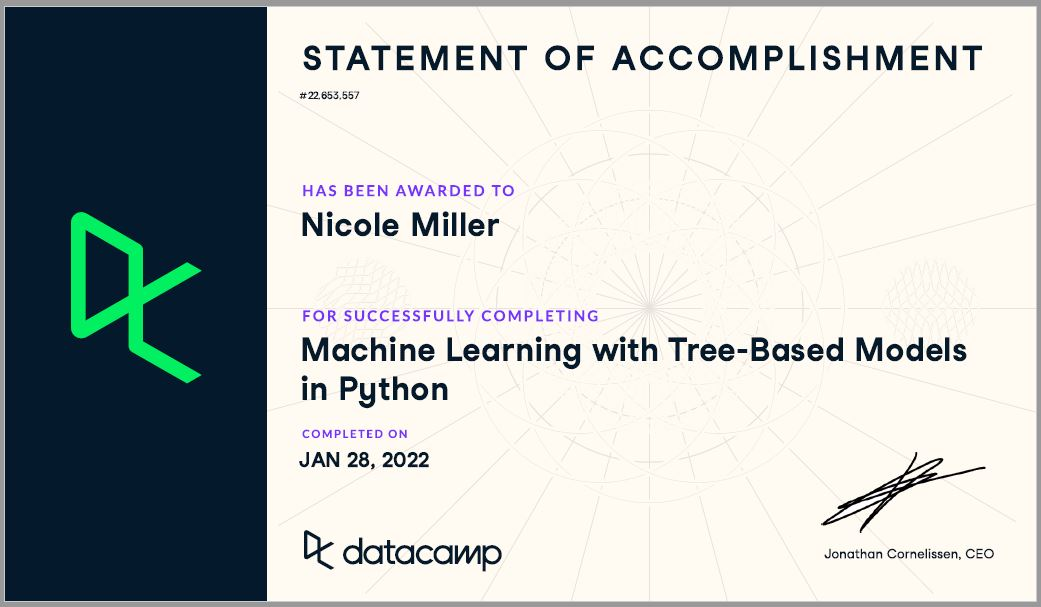